In [28]:
import numpy as np
from scipy.spatial.distance import euclidean
import scipy
import torch

import dtw
from fastdtw import fastdtw

from src.speech_classification.audio_processing import AudioPreprocessorFbank, SpeechCommandsDataCollector
from src.siamese_net_sound_similarity.train import SiameseSpeechCommandsDataCollector, SiameseLSTMNet

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()

%matplotlib inline

## Load data

In [2]:
wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left',
                'marvin',
                'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
                'up', 'wow', 'yes', 'zero']

wanted_words_combined = wanted_words

model_settings = {
    'dct_coefficient_count': 26,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 128,
    'winlen': 0.04,
    'winstep': 0.04
}

In [3]:
preproc = AudioPreprocessorFbank(nfilt=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

In [4]:
n_mini_batch_size = 1
data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])

(1, 23, 26)


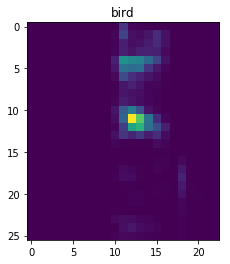

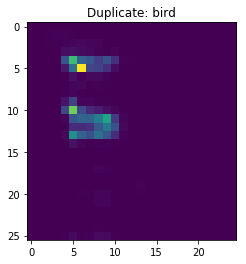

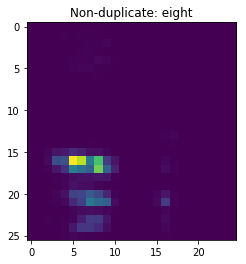

In [5]:
print(data['x'].shape)
plt.figure()
plt.imshow(data['x'].squeeze().T)
label = index_to_word[labels[0]]
plt.title(f'{label}')

plt.figure()
plt.imshow(duplicates['x'].squeeze().T)
label = index_to_word[labels[0]]
plt.title(f'Duplicate: {label}')

plt.figure()
plt.imshow(non_duplicates['x'].squeeze().T)
non_duplicate_label = index_to_word[non_duplicates['y'][0]]
plt.title(f'Non-duplicate: {non_duplicate_label}')
plt.show()

duplicates optimal path
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22)]
duplicates optimal path
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 1), (11, 2), (11, 3), (12, 4), (12, 5), (12, 6), (12, 7), (12, 8), (12, 9), (12, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18), (19, 19), (19, 20), (19, 21), (20, 22), (21, 23), (22, 24)]
non-duplicates optimal path
[(0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (8, 10), (8, 11), (9, 12), (9, 13), (10, 14), (11, 15), (12, 16), (13, 17), (14, 18), (15, 19), (15, 20), (15, 21), (16, 22), (16, 23), (17, 24), (18, 24), (19, 24), (20, 24), (21, 24), (22, 24)]


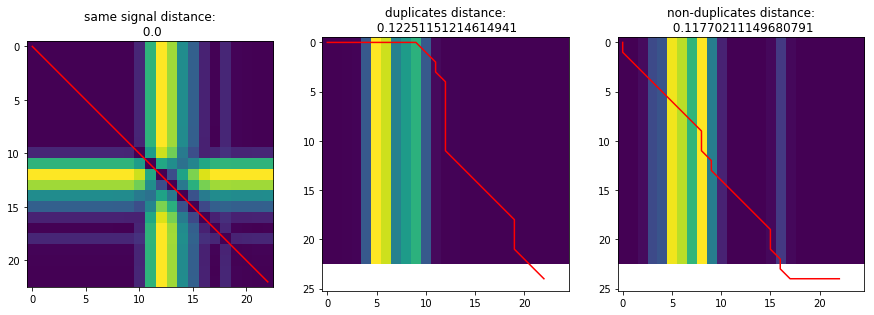

In [6]:
x = data['x'].squeeze()


fig, axes = plt.subplots(1, 3, figsize=(15,5))


# same thing dtw]

y = data['x'].squeeze()
res = dtw.dtw(x, y, dist=euclidean)

axes[0].imshow(res[1])
axes[0].plot(res[3][0], res[3][1], color='r')
axes[0].title.set_text(f'same signal distance:\n {res[0]}')
print('duplicates optimal path')
print(list(zip(*res[3])))

# duplicates dtw

y = duplicates['x'].squeeze()
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[1].imshow(res[1])
axes[1].plot(res[3][0], res[3][1], color='r')
axes[1].title.set_text(f'duplicates distance:\n {res[0]}')
print('duplicates optimal path')
print(list(zip(*res[3])))


# non-duplicates dtw

y = non_duplicates['x'].squeeze()
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[2].imshow(res[1])
axes[2].plot(res[3][0], res[3][1], color='r')
axes[2].title.set_text(f'non-duplicates distance:\n {res[0]}')
print('non-duplicates optimal path')
print(list(zip(*res[3])))

duplicates optimal path
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (9, 16), (9, 17), (9, 18), (9, 19), (9, 20), (9, 21), (9, 22)]
duplicates optimal path
[(0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (9, 16), (9, 17), (9, 18), (9, 19), (9, 20), (9, 21), (9, 22), (9, 23), (9, 24)]
non-duplicates optimal path
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 10), (2, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (4, 18), (5, 19), (6, 20), (7, 21), (8, 22), (9, 23), (9, 24)]


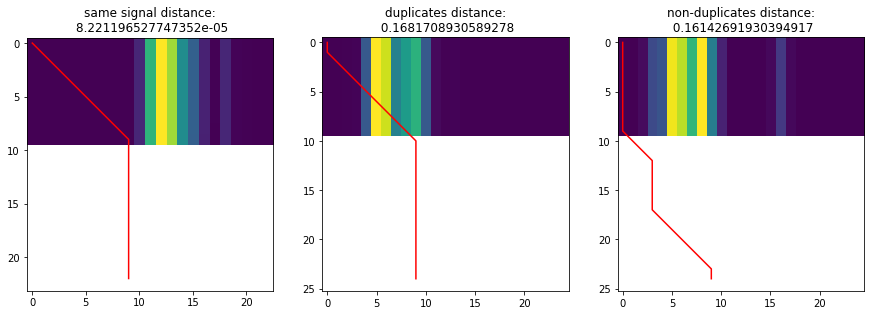

In [7]:
x = data['x'].squeeze()[:10]


fig, axes = plt.subplots(1, 3, figsize=(15,5))


# same thing dtw]

y = data['x'].squeeze()
res = dtw.dtw(x, y, dist=euclidean)

axes[0].imshow(res[1])
axes[0].plot(res[3][0], res[3][1], color='r')
axes[0].title.set_text(f'same signal distance:\n {res[0]}')
print('duplicates optimal path')
print(list(zip(*res[3])))

# duplicates dtw

y = duplicates['x'].squeeze()
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[1].imshow(res[1])
axes[1].plot(res[3][0], res[3][1], color='r')
axes[1].title.set_text(f'duplicates distance:\n {res[0]}')
print('duplicates optimal path')
print(list(zip(*res[3])))


# non-duplicates dtw

y = non_duplicates['x'].squeeze()
res = dtw.dtw(x, y, dist=euclidean)

# plt.figure()
axes[2].imshow(res[1])
axes[2].plot(res[3][0], res[3][1], color='r')
axes[2].title.set_text(f'non-duplicates distance:\n {res[0]}')
print('non-duplicates optimal path')
print(list(zip(*res[3])))

# Gather Data for analysis

In [80]:
n_mini_batch_size = 1000

# gather data


data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])


## DTW distribution on raw data

In [81]:

# initialize dist_lists

duplicates_dtw = []
non_duplicates_dtw = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = data['x'][i].squeeze()
    
    y_duplicate = duplicates['x'][i].squeeze()
    duplicates_dtw.append(dtw.dtw(x, y_duplicate, dist=euclidean)[0])

    y_non_duplicate = non_duplicates['x'][i].squeeze()
    non_duplicates_dtw.append(dtw.dtw(x, y_non_duplicate, dist=euclidean)[0])    

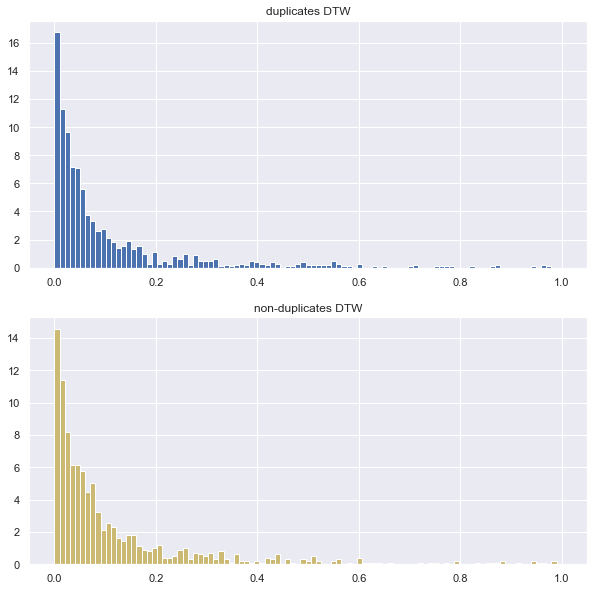

In [82]:
bins = np.linspace(0, 1, 100)
fig, axes = plt.subplots(2, 1, figsize=(10,10))

axes[0].hist(duplicates_dtw, bins=bins,density=True)
axes[0].title.set_text('duplicates DTW')

axes[1].hist(non_duplicates_dtw, bins=bins, color='y', density=True)
axes[1].title.set_text('non-duplicates DTW')
plt.show()

### KL Divergence between two DTW distributions:

In [83]:
hist_dup, _ = np.histogram(duplicates_dtw, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")


DKL is: 0.1267


### As it can be seen, DTW calculated on MFCCs signals failed to capture different and similar samples showing no significant difference between duplicates and non-duplicates pairs. Kullback-Leibler divergence just proves this fact that P (distribution of distances between duplicate samples) and Q (non-duplicate ones) have no significant difference.

# Improving DTW using latent variables from LSTM classifier as a signal

In [84]:
# load nn

nn_fname = r'C:/Study/SpeechAcquisitionModel/reports/seamise_net_09_10_2019_02_39_PM/net_0.4462033808231354.net'
nn = torch.load(nn_fname)

In [85]:
nn_input = torch.from_numpy(data['x']).cuda().float()

In [86]:
z, _ = nn.single_forward(nn_input)
z = z.detach().cpu().numpy()

duplicates_z, _ = nn.single_forward(torch.from_numpy(duplicates['x']).cuda().float())
duplicates_z = duplicates_z.detach().cpu().numpy()

non_duplicates_z, _ = nn.single_forward(torch.from_numpy(non_duplicates['x']).cuda().float())
non_duplicates_z = non_duplicates_z.detach().cpu().numpy()

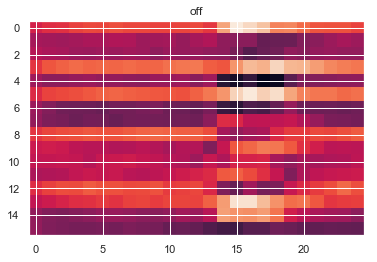

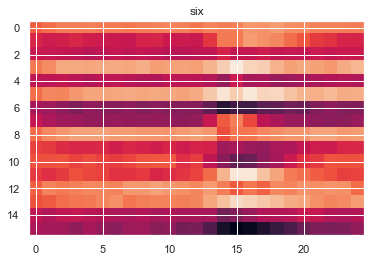

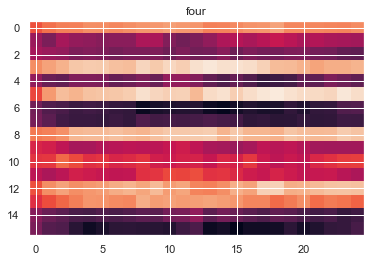

In [87]:
plt.figure()
res = plt.imshow(out[0].T)
label = index_to_word[data['y'][0]]
_ = plt.title(f'{label}')

plt.figure()
res = plt.imshow(out[10].T)
label = index_to_word[data['y'][10]]
_ = plt.title(f'{label}')

plt.figure()
res = plt.imshow(out[20].T)
label = index_to_word[data['y'][20]]
_ = plt.title(f'{label}')


# DTW distribution in latent space z

In [88]:

# initialize dist_lists

duplicates_dtw_z = []
non_duplicates_dtw_z = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = z[i].squeeze()
    
    y_duplicate = duplicates_z[i].squeeze()
    duplicates_dtw_z.append(dtw.dtw(x, y_duplicate, dist=euclidean)[0])

    y_non_duplicate = non_duplicates_z[i].squeeze()
    non_duplicates_dtw_z.append(dtw.dtw(x, y_non_duplicate, dist=euclidean)[0])    

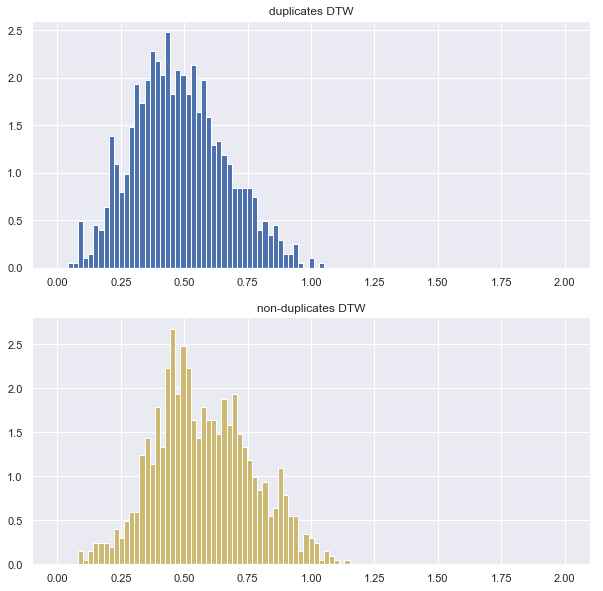

In [89]:
bins = np.linspace(0, 2, 100)
fig, axes = plt.subplots(2, 1, figsize=(10,10))

axes[0].hist(duplicates_dtw_z, bins=bins,density=True)
axes[0].title.set_text('duplicates DTW')

axes[1].hist(non_duplicates_dtw_z, bins=bins, color='y', density=True)
axes[1].title.set_text('non-duplicates DTW')
plt.show()

### KL Divergence between two DTW distributions:

In [90]:
hist_dup, _ = np.histogram(duplicates_dtw_z, bins=bins)
hist_dup = hist_dup / np.sum(hist_dup)

hist_non_dup, _ = np.histogram(non_duplicates_dtw_z, bins=bins)
hist_non_dup = hist_non_dup / np.sum(hist_non_dup)

dkl = scipy.special.kl_div(hist_dup+1e-5, hist_non_dup+1e-5).sum()
print(f"DKL is: {dkl:.4f}")


DKL is: 0.1909
